In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score

# KLASIFIKACIJA KNN algoritmom

Za svaku supstancu postoji vise klasa koje mogu da se klasifikuju, stoga radice se klasifikacija svake supstance posebno

### UCITAVANJE I PREPROCESIRANJE PODATAKA
*deo koda uzet iz fajla za analizu podataka*

In [428]:
sirovi_podaci = pd.read_csv('drug_consumption.data')
sirovi_podaci #fale imena atributa

#procitano sa sajtu podataka 
kolone = ["ID", "Age", "Gender", "Education", "Country", "Ethnicity", 
            "Nscore", "Escore", "Oscore", "Ascore", "Cscore", "Impulsiveness", "SS", 
            "Alchocol", "Amphet", "Amyl", "Benzos", "Caff", "Canabis", "Choc", "Coke", "Crack", "Ecstasy", 
            "Heroin", "Ketamin", "LegalH", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA"]

sirovi_podaci = pd.read_csv('drug_consumption.data', names = kolone)

podaci = sirovi_podaci.copy()

#ID mi ne igra nikakvu ulogu svakako
podaci = podaci.drop('ID', axis = 1)

#lazna droga
podaci = podaci.drop('Semer', axis = 1)

In [429]:
podaci
print(f'Broj istanci: {podaci.shape[0]}')
print(f'Broj atributa: {podaci.shape[1]}')
podaci.describe()

Broj istanci: 1885
Broj atributa: 30


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [430]:
podaci.isna().any().any() #nema nedostajucih vrednosti, sto je dobro

False

In [431]:
# posto imamo vise klasa koje ispitujemo, razdvajam podatke na atribute i na klase
podaci.head()

#izdvajanje atributa
atributi1 = podaci.columns
atributi1

atributi = []
for atribut in atributi1:
    if atribut == 'Alchocol':
        break
    atributi.append(atribut)
    
print(atributi, end = ', ')

['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsiveness', 'SS'], 

In [421]:
#izdvajanje klasa
klase = []
for atribut in atributi1:
    if atribut not in atributi:
        klase.append(atribut)
        
print(klase, end = ', ')
print()

# provera deljenja kolona
print(len(klase) + len(atributi) == len(podaci.columns))

['Alchocol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Canabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamin', 'LegalH', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'VSA'], 
True


In [432]:
# podaci bez klasa
podaci_bez_klasa = podaci.copy()
for x in klase:
    podaci_bez_klasa = podaci_bez_klasa.drop(x, axis = 1)
podaci_bez_klasa

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470


In [433]:
#skaliramo podatke, trebace zbog KNN-a
def skaliraj_podatke(X):
    return (X - min(X))/(max(X) - min(X))

In [434]:
# skalirani_podaci = podaci.copy()
# for a in atributi:
#     skalirani_podaci[a] = skaliraj_podatke(skalirani_podaci[a])
    
# #provera uspesnosti skaliranja
# for a in atributi:
#     print(len(skalirani_podaci[a].unique()) == len(podaci[a].unique()), end = ", ")
    
# #nismo izgubili podatke

In [435]:
podaci_skalirano = skalirani_podaci.copy()

In [436]:
for x in klase:
    podaci_skalirano = podaci_skalirano.drop(x, axis = 1)
podaci_skalirano

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS
0,0.409137,1.0,0.537681,1.000000,0.409061,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398
1,0.246475,0.0,1.000000,1.000000,0.262143,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658
2,0.409137,0.0,0.537681,1.000000,0.262143,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957
3,0.000000,1.0,0.814329,1.000000,0.262143,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398
4,0.409137,1.0,1.000000,1.000000,0.262143,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658
...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.000000,0.262143,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000
1881,0.000000,0.0,0.412820,0.000000,0.262143,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933
1882,0.246475,1.0,0.653938,0.000000,0.262143,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117
1883,0.000000,1.0,0.412820,0.000000,0.262143,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752


# KLASIFIKACIJA 

In [369]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# POMOCNA FJA ZA GRAFICKI PRIKAZ, kod uzet sa vezbi
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
from termcolor import colored, cprint


def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
#     vrste = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    kolone = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns = kolone, index = kolone))
    print("---------------------------------------------------------------------------------")

def report(model, x, y, text = "trening", ):
    y_pred = model.predict(x)
    
    print(colored('\t' + f'Klasifikacioni izveštaj za model {type(model).__name__} nad {text} podacima', 'blue', attrs= ['bold']))
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])
    cprint(classification_report(y, y_pred), attrs= ['dark']) 
    cprint('----------------------------------------------------------------------------------------------', attrs= ['bold'])

In [437]:
X, y = podaci_bez_klasa, podaci['Alchocol']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)

In [438]:
knn = KNeighborsClassifier(n_neighbors = 80)

In [439]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=80)

In [440]:
report_imbalanced(knn, X_train, y_train)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       1.00      0.00      1.00      0.00      0.00      0.00        24
        CL1       1.00      0.00      1.00      0.00      0.00      0.00        24
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        48
        CL3       1.00      0.01      1.00      0.01      0.09      0.01       138
        CL4       0.29      0.01      1.00      0.02      0.10      0.01       201
        CL5       0.42      0.97      0.10      0.59      0.31      0.10       531
        CL6       0.47      0.11      0.95      0.18      0.32      0.10       353

avg / total       0.52      0.42      0.62      0.29      0.24      0.07      1319

---------------------------------------------------------------------------------
Confusion matrix

In [441]:
report_imbalanced(knn, X_test, y_test)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL1       1.00      0.00      1.00      0.00      0.00      0.00        10
        CL2       1.00      0.00      1.00      0.00      0.00      0.00        20
        CL3       1.00      0.00      1.00      0.00      0.00      0.00        60
        CL4       0.67      0.02      1.00      0.04      0.15      0.02        86
        CL5       0.41      0.93      0.08      0.57      0.28      0.08       228
        CL6       0.38      0.10      0.94      0.16      0.30      0.08       152

avg / total       0.54      0.41      0.61      0.28      0.22      0.06       566

---------------------------------------------------------------------------------
Confusion matrix

radi slicno kao stabla

In [442]:
# cackanje parametara
parametri = {
    'n_neighbors' : [x for x in range(4, 20)],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'kd_tree']
}

In [443]:
grid = GridSearchCV(knn, param_grid = parametri, scoring='accuracy', cv=3, verbose=4)

In [444]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END algorithm=auto, n_neighbors=4, weights=uniform;, score=0.282 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=4, weights=uniform;, score=0.348 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=4, weights=uniform;, score=0.305 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=4, weights=distance;, score=0.320 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=4, weights=distance;, score=0.332 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=4, weights=distance;, score=0.312 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, weights=uniform;, score=0.291 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=5, weights=uniform;, score=0.350 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=5, weights=uniform;, score=0.317 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=5, weights=distance;, score=0.320 total time=   0.0s
[CV 

[CV 3/3] END algorithm=kd_tree, n_neighbors=4, weights=distance;, score=0.312 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.291 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.350 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, n_neighbors=5, weights=uniform;, score=0.317 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.320 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.352 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, n_neighbors=5, weights=distance;, score=0.337 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=0.316 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=0.361 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, n_neighbors=6, weights=uniform;, score=0.319 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, n_ne

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_neighbors=80),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=4)

In [445]:
ocena = grid.best_score_
najbolji_parametri = grid.best_params_

In [446]:
print(ocena, najbolji_parametri) #malo bolje radi

0.39120590874577205 {'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'distance'}


In [447]:
# balansiranje klasa

In [448]:
from collections import Counter
from matplotlib import pyplot as plt
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled
    
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    """
        x_opacity - [0, 1] -> prozirnost elemenata klase (podešavati u odnosu na to da li prikazujemo samo 1 klasu ili obe)
    """
    
    #Da bismo vizuelizovali, iskoristicemo PCA da smanjimo na 2 dimenzije
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c = 'blue' if i else 'green')
    plt.show()


In [449]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    model = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 18, weights='distance')
    model.fit(X_train, Y_train)
    report_imbalanced(model, X_train, Y_train)
    report_imbalanced(model, X_test, Y_test)
    return model

In [450]:
from collections import Counter

In [451]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

Number of instances before resampling with SMOTEENN : dict_items([('CL5', 531), ('CL4', 201), ('CL6', 353), ('CL3', 138), ('CL2', 48), ('CL1', 24), ('CL0', 24)]). 
Number of instances after  resampling with SMOTEENN : dict_items([('CL0', 523), ('CL1', 529), ('CL2', 508), ('CL3', 441), ('CL4', 327), ('CL5', 20), ('CL6', 131)]). 


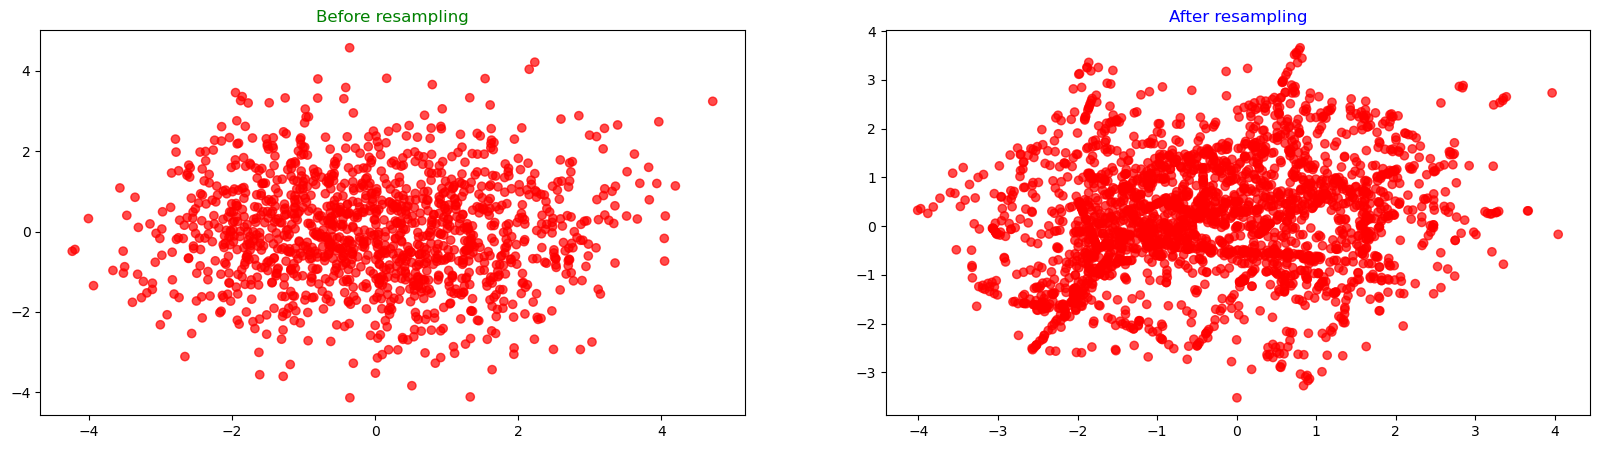

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        CL0       1.00      1.00      1.00      1.00      1.00      1.00       523
        CL1       1.00      1.00      1.00      1.00      1.00      1.00       529
        CL2       1.00      1.00      1.00      1.00      1.00      1.00       508
        CL3       1.00      1.00      1.00      1.00      1.00      1.00       441
        CL4       1.00      1.00      1.00      1.00      1.00      1.00       327
        CL5       1.00      1.00      1.00      1.00      1.00      1.00        20
        CL6       1.00      1.00      1.00      1.00      1.00      1.00       131

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      2479

---------------------------------------------------------------------------------
Confusion matrix

In [452]:
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
smoteenn = SMOTEENN(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = resample(smoteenn, X_train, y_train)
visualize(X_train, X_resampled, y_train, y_resampled, 0.3)
model_smoteenn = train_and_evaluate_model(X_resampled, y_resampled, X_test, y_test)

In [453]:
najbolji_parametri

{'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'distance'}

In [460]:


n = len(klase)
preciznosti = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_bez_klasa, podaci[klase[i]], test_size = 0.30,  random_state = 42)
    
    for a in atributi:
        X_train[a] = skaliraj_podatke(X_train[a])
        X_test[a] = skaliraj_podatke(X_test[a])
    
    knn_i = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 18, weights='uniform')
    knn_i.fit(X_train, y_train)
    print(klase[i])
    report(knn_i, X_test, y_test, text= 'test')
    
    predicted = knn_i.predict(X_test)
    preciznosti.append(accuracy_score(y_test, predicted))

Alchocol
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00        11
         CL1       0.00      0.00      0.00        11
         CL2       0.00      0.00      0.00        24
         CL3       0.18      0.05      0.08        60
         CL4       0.25      0.03      0.06        96
         CL5       0.42      0.78      0.54       229
         CL6       0.30      0.24      0.27       135

    accuracy                           0.38       566
   macro avg       0.16      0.16      0.14       566
weighted avg       0.30      0.38      0.30       566

----------------------------------------------------------------------------------------------
Amphet
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
---------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

Canabis
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.48      0.73      0.58       123
         CL1       0.30      0.32      0.31        50
         CL2       0.33      0.21      0.26        76
         CL3       0.24      0.05      0.08        79
         CL4       0.00      0.00      0.00        43
         CL5       0.08      0.02      0.03        48
         CL6       0.43      0.71      0.54       147

    accuracy                           0.41       566
   macro avg       0.26      0.29      0.26       566
weighted avg       0.33      0.41      0.34       566

----------------------------------------------------------------------------------------------
Choc
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
------------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

Heroin
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.85      1.00      0.92       481
         CL1       0.00      0.00      0.00        15
         CL2       0.00      0.00      0.00        30
         CL3       0.00      0.00      0.00        24
         CL4       0.00      0.00      0.00         9
         CL5       0.00      0.00      0.00         4
         CL6       0.00      0.00      0.00         3

    accuracy                           0.85       566
   macro avg       0.12      0.14      0.13       566
weighted avg       0.72      0.85      0.78       566

----------------------------------------------------------------------------------------------
Ketamin
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

Mushrooms
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.64      0.82      0.72       288
         CL1       0.46      0.10      0.16        61
         CL2       0.21      0.09      0.13        77
         CL3       0.33      0.55      0.41        84
         CL4       0.00      0.00      0.00        39
         CL5       0.00      0.00      0.00        13
         CL6       0.00      0.00      0.00         4

    accuracy                           0.52       566
   macro avg       0.23      0.22      0.20       566
weighted avg       0.45      0.52      0.46       566

----------------------------------------------------------------------------------------------
Nicotine
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [461]:
preciznosti_obicno = [round(x, 4) for x in preciznosti]

In [462]:
preciznosti_obicno

[0.3834,
 0.5194,
 0.6961,
 0.5283,
 0.735,
 0.4099,
 0.4311,
 0.5636,
 0.8693,
 0.553,
 0.8481,
 0.7898,
 0.5954,
 0.5813,
 0.7385,
 0.523,
 0.371,
 0.7703]

# pokusavam da dodam atribute koristeci i ostale klase

In [463]:
podaci_skalirano = podaci.copy()

n = len(podaci_skalirano['Heroin'])
    
for x in klase:
    for i in range(n):
        podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))
    print(podaci_skalirano[x].unique())
        

podaci_skalirano

/tmp/ipykernel_14822/2619896397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podaci_skalirano[x][i] = int(podaci_skalirano[x][i].strip('CL'))


[5 6 4 2 1 0 3]
[2 0 1 3 5 4 6]
[0 2 1 3 5 4 6]
[2 0 3 1 4 5 6]
[6 5 4 3 0 1 2]
[0 4 3 2 1 6 5]
[5 6 4 0 3 2 1]
[0 3 2 1 6 5 4]
[0 1 2 3 5 4 6]
[0 4 1 3 2 6 5]
[0 1 2 3 5 6 4]
[0 2 3 1 5 4 6]
[0 1 2 3 5 4 6]
[0 2 1 3 4 5 6]
[0 3 1 6 4 2 5]
[0 1 2 3 4 5 6]
[2 4 0 6 1 3 5]
[0 1 3 6 2 5 4]


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Crack,Ecstasy,Heroin,Ketamin,LegalH,LSD,Meth,Mushrooms,Nicotine,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,0,2,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,4,0,2,0,2,3,0,4,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,1,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,2,0,0,0,0,2,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,1,0,0,1,0,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,...,0,0,0,0,3,3,0,0,0,5
1881,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,...,0,2,0,0,3,5,4,4,5,0
1882,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,...,0,4,0,2,0,2,0,2,6,0
1883,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,...,0,3,0,0,3,3,0,3,4,0


In [464]:
# treba mi za klasifikaciju
for x in klase:
    podaci_skalirano[x] = podaci_skalirano[x].astype('float64')

In [465]:
# #skaliram podatke
# for a in atributi:
#     podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
# for a in klase:
#     podaci_skalirano[a] = skaliraj_podatke(podaci_skalirano[a])
# podaci_skalirano.describe()

In [466]:
#pravi skupove podataka pojedinacno bez svake klase
podaci_bez_klase = []
for x in klase:
    podaci_bez_klase.append(podaci_skalirano.drop(x, axis = 1))
    
#klasni_podaci, isto to
klasni_podaci = []
n = len(klase)
for i in range(n):
    klasni_podaci.append(podaci[klase[i]])
    
len(podaci_bez_klase)

18

In [467]:
#delimo podatke na train/test skupove
n = len(podaci_bez_klase)
preciznosti_sve = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(podaci_bez_klase[i], klasni_podaci[i], test_size = 0.30,  random_state = 42)

    for a in atributi:
        X_train[a] = skaliraj_podatke(X_train[a])
        X_test[a] = skaliraj_podatke(X_test[a])
    
    
    knn_i = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 18, weights='distance')
    knn_i.fit(X_train, y_train)
    print(klase[i])
    report(knn_i, X_test, y_test, text= 'test')
    
    predicted = knn_i.predict(X_test)
    preciznosti_sve.append(round(accuracy_score(y_test, predicted), 4))


Alchocol
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00        11
         CL1       0.00      0.00      0.00        11
         CL2       0.40      0.08      0.14        24
         CL3       0.25      0.05      0.08        60
         CL4       0.17      0.03      0.05        96
         CL5       0.40      0.72      0.51       229
         CL6       0.25      0.22      0.24       135

    accuracy                           0.36       566
   macro avg       0.21      0.16      0.15       566
weighted avg       0.29      0.36      0.29       566

----------------------------------------------------------------------------------------------
Amphet
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
---------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

              precision    recall  f1-score   support

         CL0       0.76      0.91      0.83       311
         CL1       0.36      0.08      0.13        51
         CL2       0.33      0.40      0.36        72
         CL3       0.30      0.39      0.34        75
         CL4       0.00      0.00      0.00        37
         CL5       0.00      0.00      0.00        13
         CL6       0.00      0.00      0.00         7

    accuracy                           0.61       566
   macro avg       0.25      0.25      0.24       566
weighted avg       0.53      0.61      0.56       566

----------------------------------------------------------------------------------------------
Crack
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.88      0.98      0.93       492
         CL1       0.00  

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

Mushrooms
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
----------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         CL0       0.73      0.85      0.78       288
         CL1       0.29      0.15      0.20        61
         CL2       0.38      0.38      0.38        77
         CL3       0.42      0.57      0.48        84
         CL4       0.33      0.05      0.09        39
         CL5       0.00      0.00      0.00        13
         CL6       0.00      0.00      0.00         4

    accuracy                           0.59       566
   macro avg       0.31      0.29      0.28       566
weighted avg       0.54      0.59      0.55       566

----------------------------------------------------------------------------------------------
Nicotine
	Klasifikacioni izveštaj za model KNeighborsClassifier nad test podacima
------------------------------------------------

/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dzzz/.local/lib/python3.10/site-packa

In [468]:
preciznosti_sve

[0.3569,
 0.6007,
 0.7102,
 0.5848,
 0.7332,
 0.4382,
 0.4576,
 0.6078,
 0.8587,
 0.6378,
 0.8551,
 0.788,
 0.6042,
 0.6396,
 0.7562,
 0.5901,
 0.447,
 0.758]

# REZULTATI

In [469]:
#preciznosti_obicno, preciznosti_sve

In [470]:
print(len(preciznosti_obicno), len(preciznosti_sve))

18 18


In [471]:
modeli = ["Knn", "Knn sve klase"]

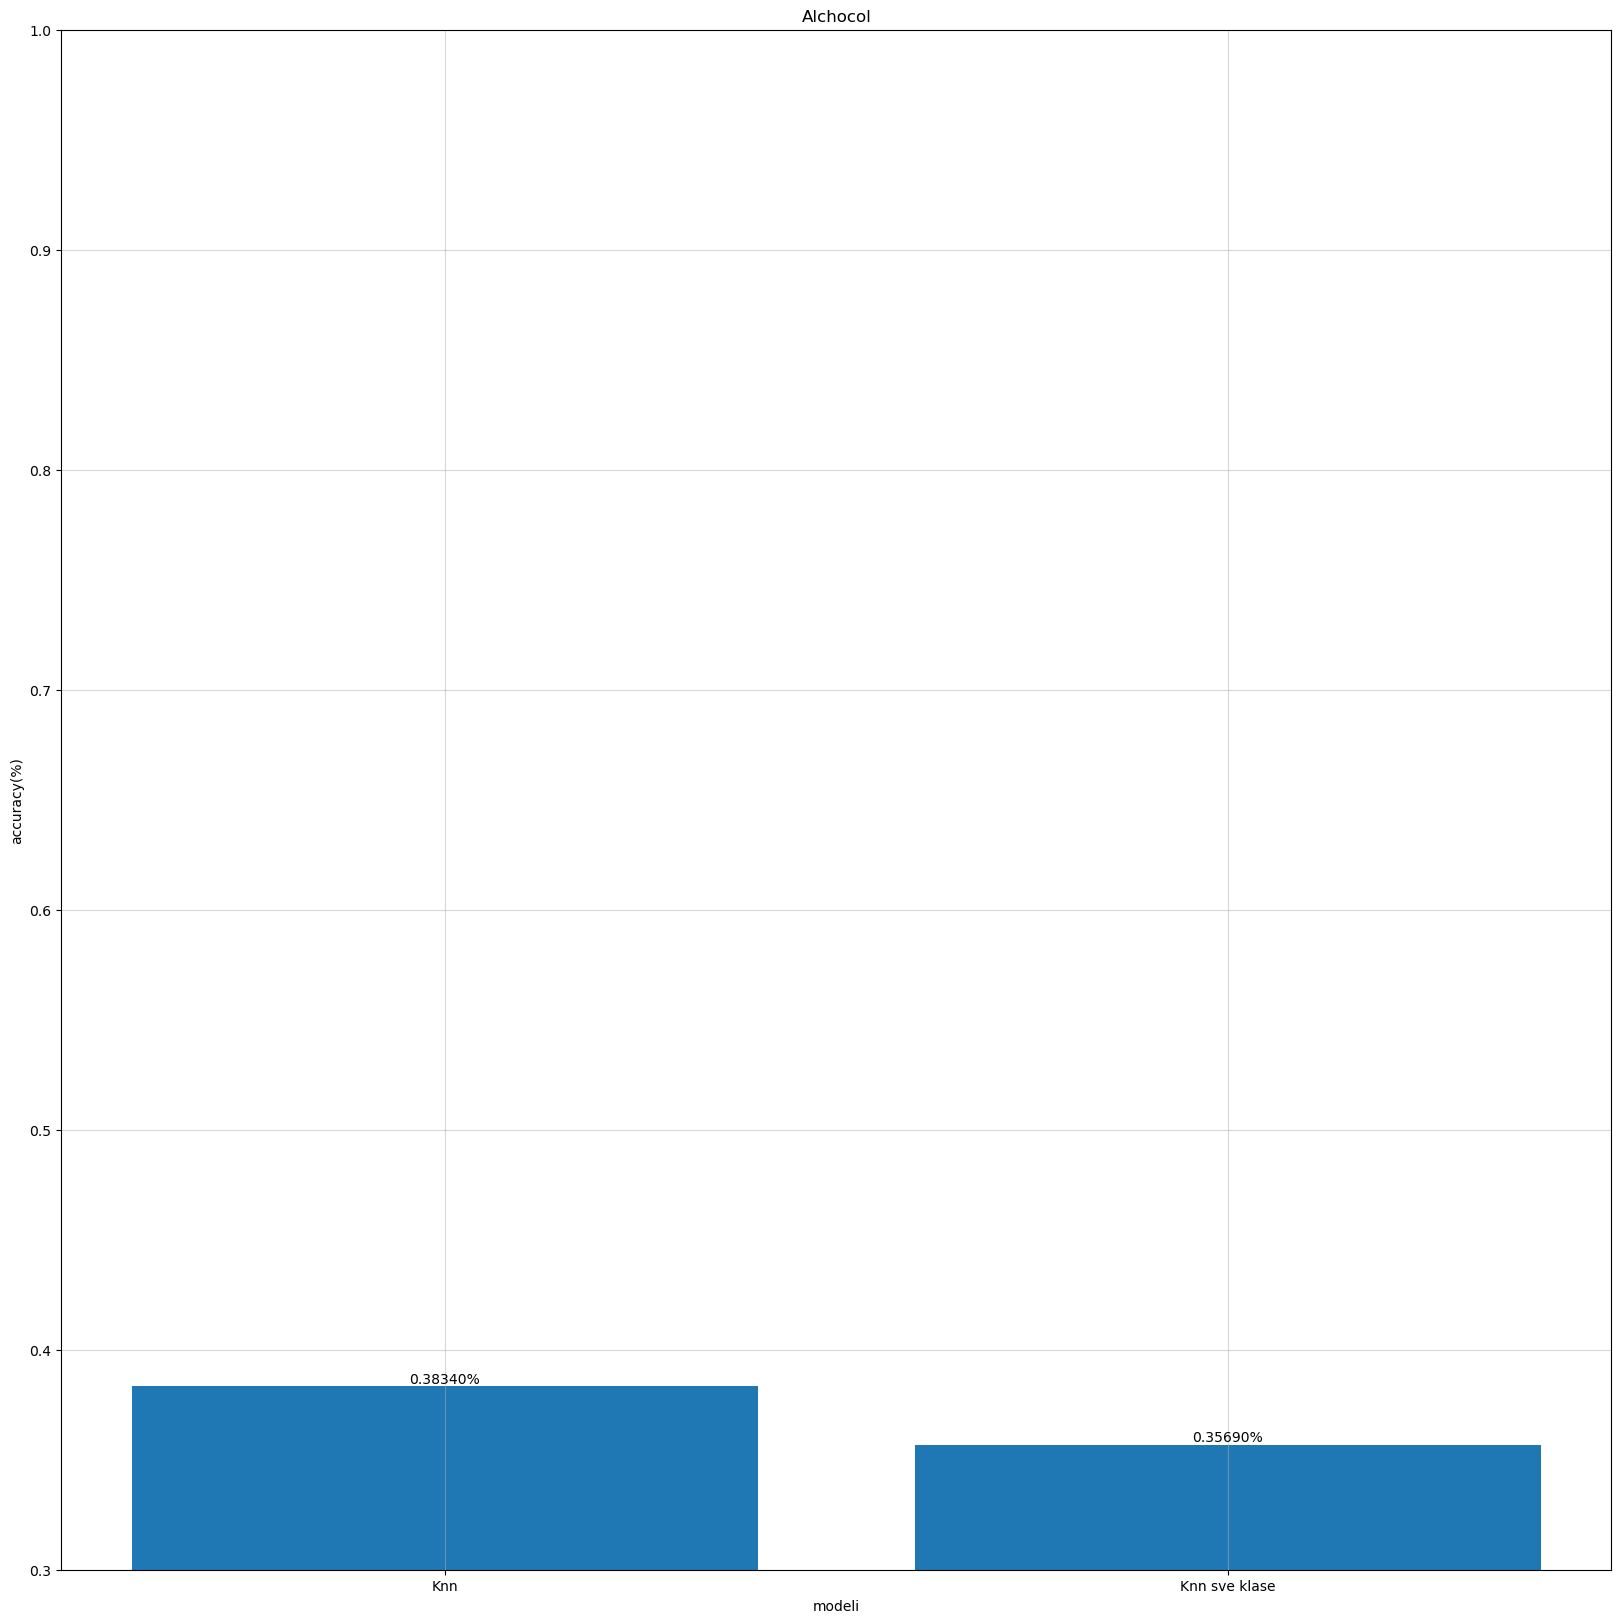

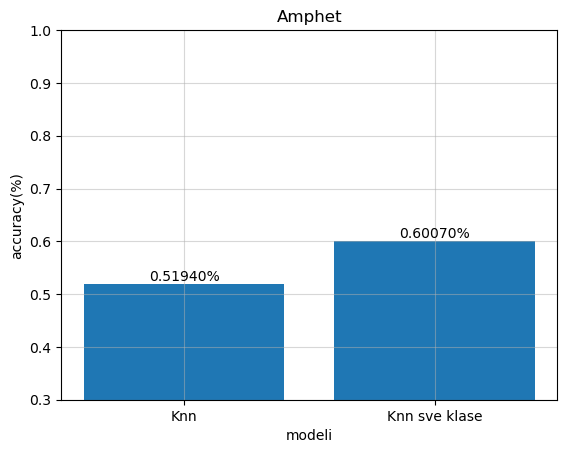

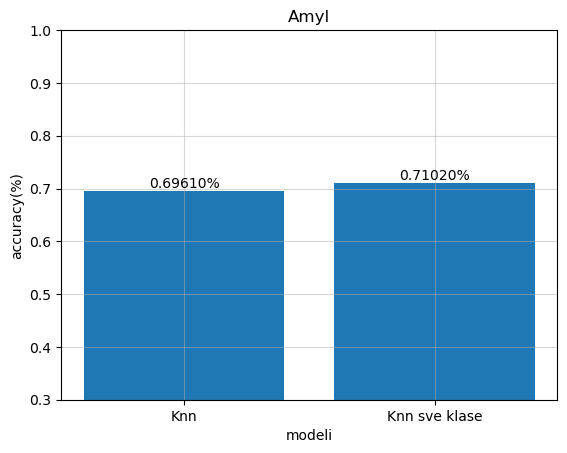

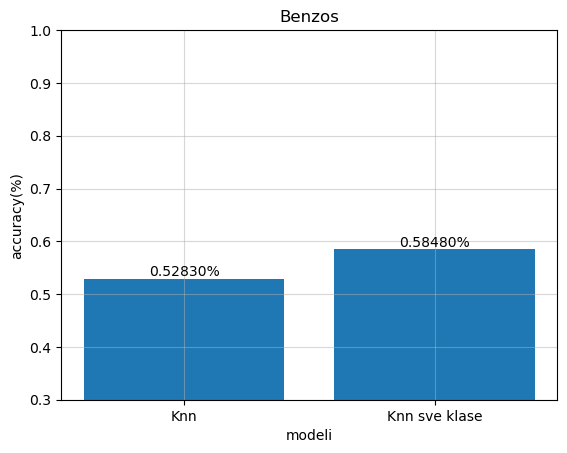

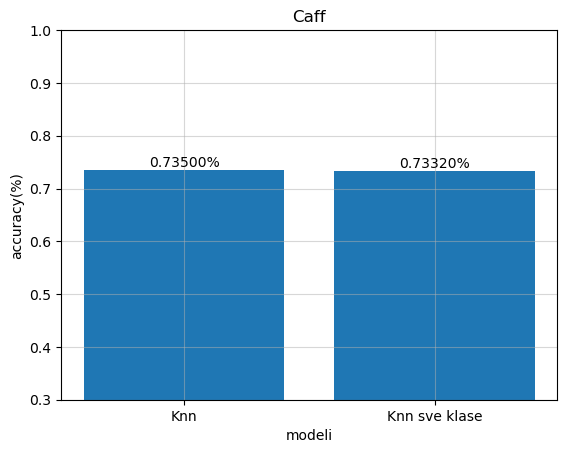

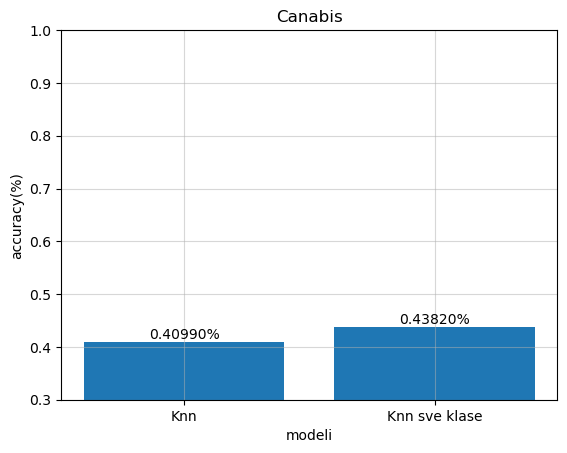

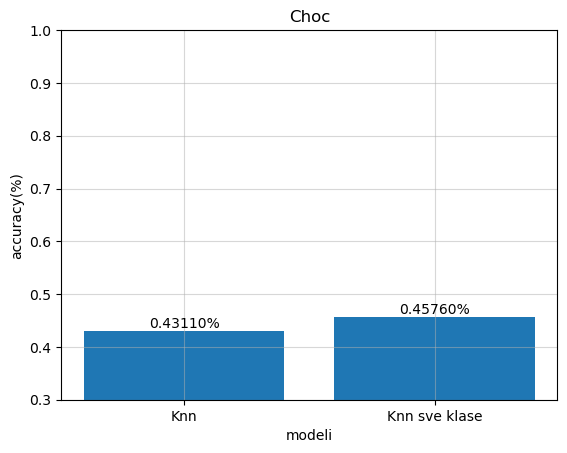

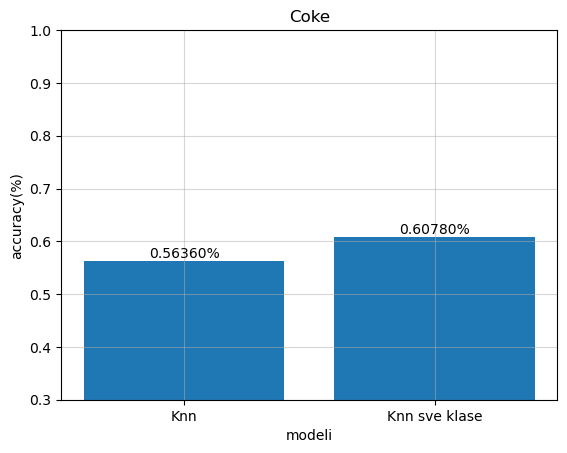

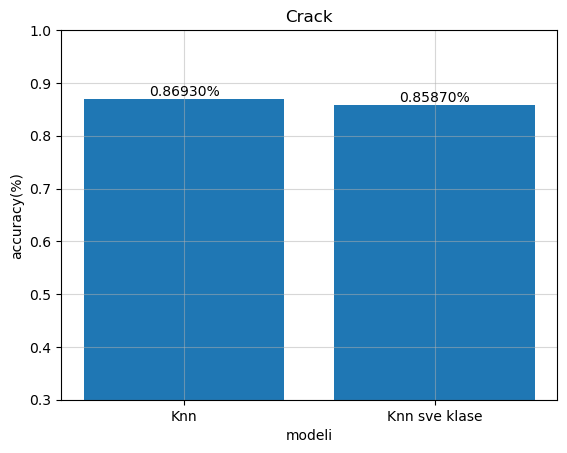

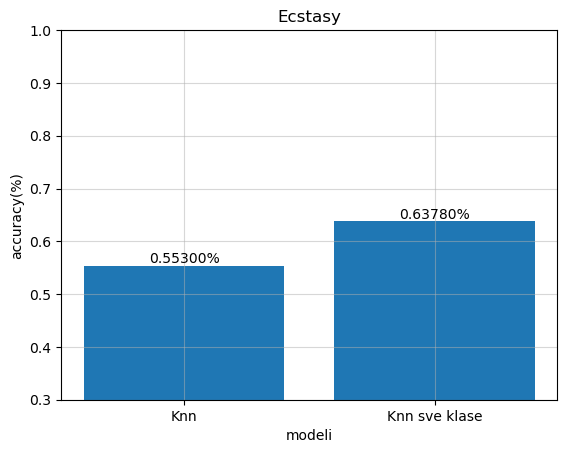

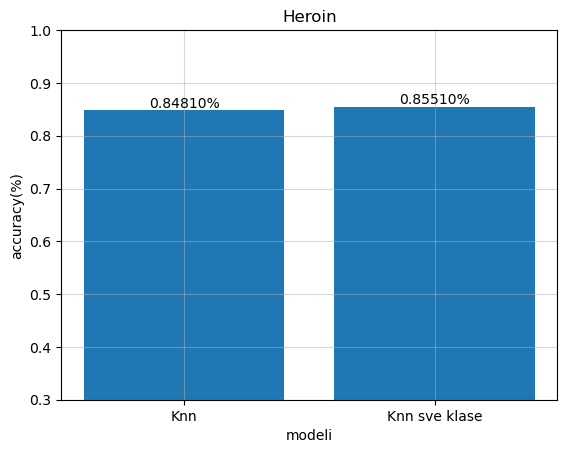

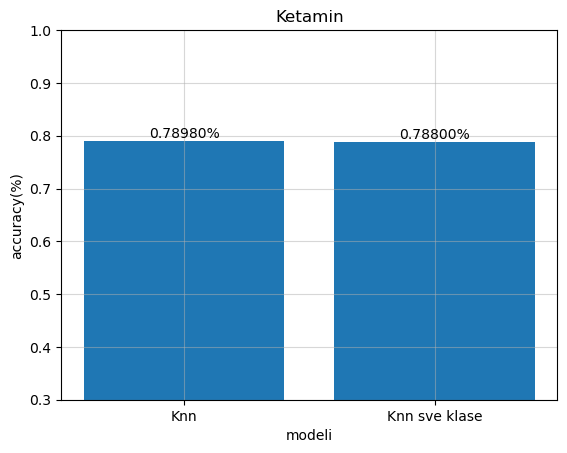

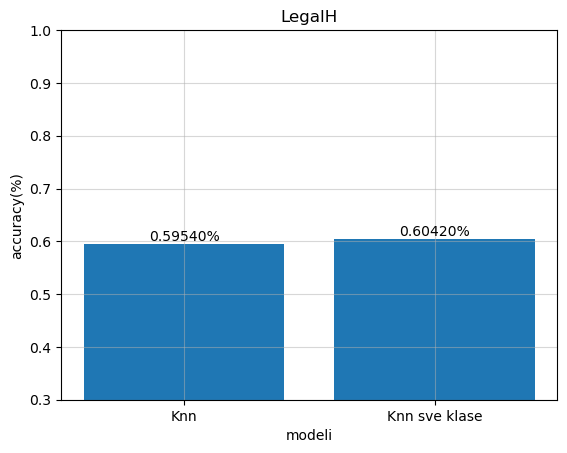

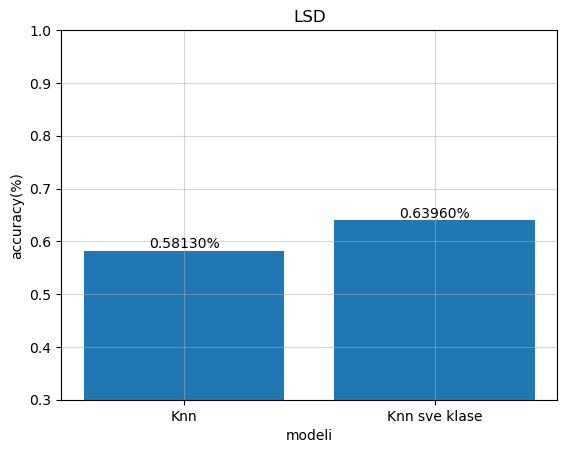

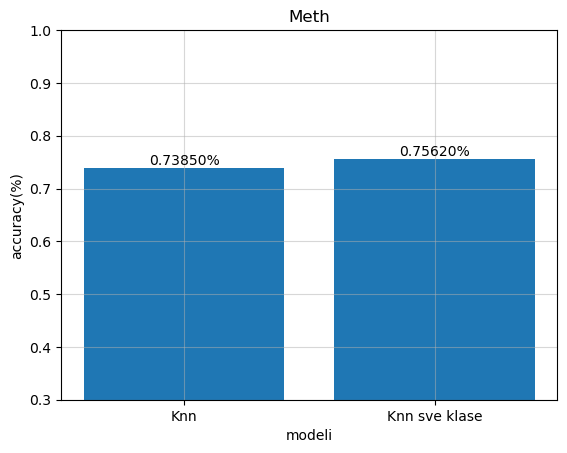

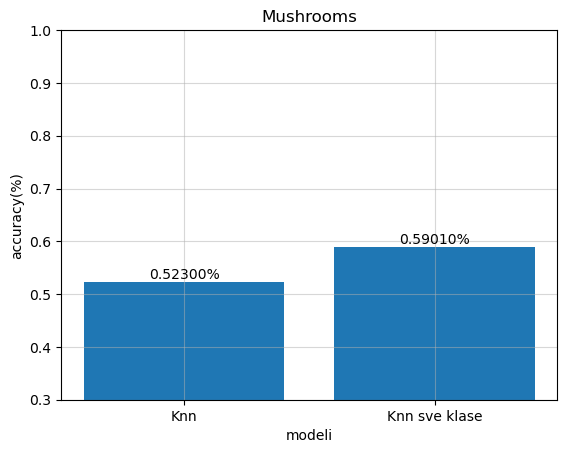

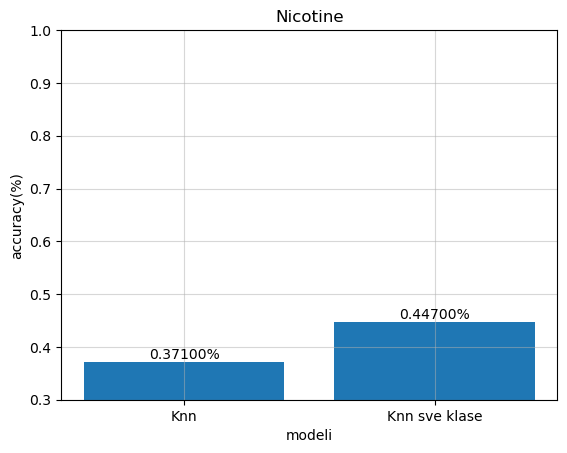

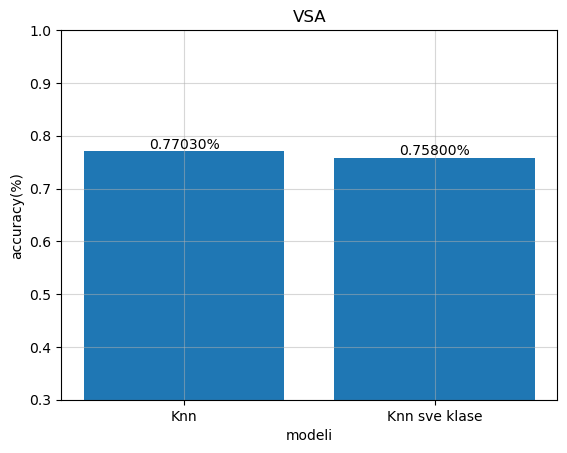

In [472]:
plt.figure(figsize = (20, 20))
for i in range(n):
    plt.title(f'{klase[i]}')
    vrednosti = [preciznosti_obicno[i], preciznosti_sve[i]]
    plt.bar(modeli, vrednosti)
    plt.grid(alpha = 0.5)
    plt.ylim(0.3, 1.0)
    for j, s in enumerate(vrednosti):
        plt.text(modeli[j], s, f'{s:.5f}%', ha='center', va='bottom')
    plt.xlabel('modeli')
    plt.ylabel('accuracy(%)')
    plt.show()


In [473]:
def prosek(niz):
    return sum(niz) / len(niz)
proseci = [prosek(preciznosti_obicno), prosek(preciznosti_sve)]

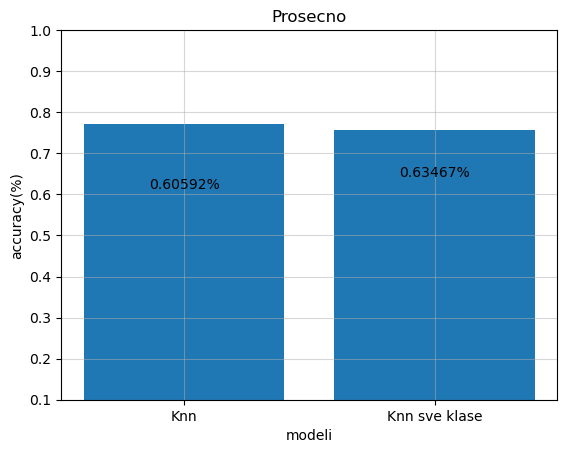

In [474]:
plt.title("Prosecno")
plt.bar(modeli, vrednosti)
plt.grid(alpha = 0.5)
plt.ylim(0.1, 1.0)
for j, s in enumerate(proseci):
    plt.text(modeli[j], s, f'{s:.5f}%', ha='center', va='bottom')
plt.xlabel('modeli')
plt.ylabel('accuracy(%)')
plt.show()

In [475]:
najbolji_parametri

{'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'distance'}

In [476]:
# eksport modela
knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 18, weights = 'uniform')

In [477]:
import joblib
joblib.dump(knn, 'KNN.pkl')

['KNN.pkl']